# 同一人物の識別に挑戦する
日高光啓さんは、スーパーパフォーマンスグループAAAのメンバーとして活動し、なおかつラッパーSKY-HIとしても活動している。
今回は、SKY-HI と AAA日高光啓 を機械学習を用いて識別できるか、挑戦をしている。

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

import os
import time
import random
import shutil
import copy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
IN_DIR = 'HIDAKA'
TRAIN_DIR = 'data/train'
TEST_DIR = 'data/val'

if not os.path.exists(TRAIN_DIR):
    os.mkdir(TRAIN_DIR)

if not os.path.exists(TEST_DIR):
    os.mkdir(TEST_DIR)
    
    
f = open('labels_hidaka.txt', 'w')
print('2 ' , file = f, sep=',', end="")
print('1123 ', file = f, sep=',', end="")
print('SKY-HI ', file = f, sep=',')
print('2000 ', file = f, sep=',', end="")
print('3114 ', file = f, sep=',', end="")
print('AAA ', file = f, sep=',')
f.close()


#labels_hidaka.txtのファイルを読み込んで、SKY-HI/AAAを入れるとその存在する範囲を返す関数を作るよ
# name => (start idx, end idx)
hidaka_dics = {}

with open('labels_hidaka.txt') as fp:
    for line in fp:
        line = line.rstrip() #文字列を右から削除
        cols = line.split() #文字列を分割

        assert len(cols) == 3 #超お手軽にテストする。条件式がFalseならアラート

        start = int(cols[0])
        end = int(cols[1])
        name = cols[2]

        hidaka_dics[name] = (start, end)


In [3]:
#AAA/SKY-HIのディレクトリ作成
for name in hidaka_dics:
    os.mkdir(os.path.join(TRAIN_DIR, name))
    os.mkdir(os.path.join(TEST_DIR, name))
    


In [4]:
# HIDAKAをスキャン
for f in sorted(os.listdir(IN_DIR)):
    # image_0001.jpg => 1
    prefix = f.replace('.jpg', '')
    idx = int(prefix)
    
    for name in hidaka_dics:
        start, end = hidaka_dics[name]
        if idx in range(start, end + 1):
            source = os.path.join(IN_DIR, f)
            dest = os.path.join(TRAIN_DIR, name)
            shutil.copy(source, dest)
            continue

# 訓練データの各ディレクトリからランダムに10枚をテストとする
for d in os.listdir(TRAIN_DIR):
    files = os.listdir(os.path.join(TRAIN_DIR, d)) #pathをtrain_images/[花]として１つ１つ繋げる
    random.shuffle(files) #花のファイル内の画像をシャッフル
    for f in files[:10]: #シャッフルしたファイルから10個選び、それをfに１つ１つ入れていく。
        source = os.path.join(TRAIN_DIR, d, f)  #train_image/[花]/[画像]のpathをつなぐ
        dest = os.path.join(TEST_DIR, d) #test_image/[花]をつなぐ
        shutil.move(source, dest) #sourceをdestファイルに移動

In [5]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [6]:
#pathを繋ぐ
#data_dir = os.path.join('data', 'HIDAKA')

#データセットの作成
image_datasets = {x: datasets.ImageFolder(os.path.join('data', x), data_transforms[x]) for x in ['train', 'val']}

#データの読み込み
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size = 4,
                                              shuffle = True,
                                              num_workers = 4) for x in ['train', 'val']}
#データのサイズを読み込む
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

#学習データクラスにラベルをつけるよ
class_names = image_datasets['train'].classes

In [7]:
#訓練画像の可視化をする準備
def imshow(images, title = None):
    images = images.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    if title is not None:
        plt.title(title)

images, classes = next(iter(dataloaders['train']))
print(images.size(), classes.size())

torch.Size([4, 3, 224, 224]) torch.Size([4])


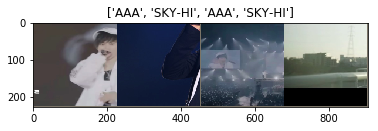

In [8]:
images = torchvision.utils.make_grid(images)
imshow(images, title=[class_names[x] for x in classes])

In [9]:
use_gpu = torch.cuda.is_available()

def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # 各エポックで訓練+バリデーションを実行
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)   # training mode
            else:
                model.train(False)  # evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            for data in dataloaders[phase]:
                inputs, labels = data
                
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # サンプル数で割って平均を求める
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            # 精度が改善したらモデルを保存する
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:.4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
#学習済みResNetをロード
model_ft = models.resnet18(pretrained=True)

In [12]:
num_features = model_ft.fc.in_features
print(num_features)

512


In [13]:
#ImageNetの出力がLinear(512, 1000)
#これを2クラス分類に適応させよう
model_ft.fc = nn.Linear(num_features, 2)

In [ ]:
if use_gpu:
    model_ft = model_ft.cuda()
    
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# 7エポックごとに学習率を0.1倍する
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)


Epoch 0/29
----------


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


train Loss: 0.7209 Acc: 0.6414
val Loss: 1.0074 Acc: 0.6000

Epoch 1/29
----------


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


train Loss: 0.7375 Acc: 0.6482
val Loss: 0.5335 Acc: 0.7000

Epoch 2/29
----------


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


train Loss: 0.7219 Acc: 0.6563
val Loss: 0.7589 Acc: 0.7500

Epoch 3/29
----------


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


train Loss: 0.6950 Acc: 0.6825
val Loss: 0.5669 Acc: 0.8000

Epoch 4/29
----------


In [157]:
torch.save(model_ft.state_dict(), 'model_new.pth')
new_model = models.densenet121()
num_features = model_ft.classifier.in_features
new_model.classifier = nn.Linear(num_features, 2)
param = torch.load('model_new.pth')
new_model.load_state_dict(param)

In [159]:
#テスト画像を入れて識別できるかな

#その前処理
normalize = transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

In [ ]:
img = Image.open('./test/SKY-HI/SUPER_FLYERS')
img_tensor = preprocess(img)
print(img_tensor.shape)

In [161]:
img_tensor.unsqueeze_(0)
print(img_tensor.size())

torch.Size([1, 3, 224, 224])


In [162]:
out = new_model(Variable(img_tensor))

In [163]:
print(out.size())

torch.Size([1, 2])


In [164]:
np.argmax(out.data.numpy())

1

In [165]:
out.topk(2)

(Variable containing:
  0.3453  0.3161
 [torch.FloatTensor of size 1x2], Variable containing:
  1  0
 [torch.LongTensor of size 1x2])

In [166]:
def predict(image_file):
    img = Image.open(image_file)
    img_tensor = preprocess(img)
    img_tensor.unsqueeze_(0)

    out = new_model(Variable(img_tensor))

    # 出力を確率にする（分類するだけなら不要）
    out = nn.functional.softmax(out, dim=1)
    out = out.data.numpy()

    maxid = np.argmax(out)
    maxprob = np.max(out)
    label = labels[maxid]
    return img, label, maxprob

AAA 0.529432


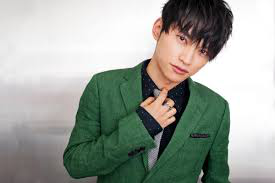

In [167]:
labels = ['SKY-HI','AAA']

img, label, prob = predict('./test/SKY-HI/GREEN.jpg')
print(label, prob)
img

In [116]:
model_ft.state_dict()

OrderedDict([('conv1.weight', 
              (0 ,0 ,.,.) = 
                6.8314e-04 -2.1979e-03  8.3543e-04  ...   6.5654e-02  2.8655e-02 -2.7425e-03
                1.3585e-02  4.5893e-03 -1.1571e-01  ...  -2.6772e-01 -1.2462e-01  6.3209e-03
               -2.1581e-03  5.7373e-02  2.9124e-01  ...   5.2715e-01  2.6430e-01  6.8301e-02
                               ...                   ⋱                   ...                
               -1.7021e-02  2.0195e-02  7.3551e-02  ...  -3.2174e-01 -4.0939e-01 -2.4891e-01
                4.2682e-02  4.6644e-02  6.5801e-02  ...   4.2732e-01  4.0620e-01  1.7510e-01
               -3.2846e-03  2.6394e-03 -1.8098e-02  ...  -1.3641e-01 -6.7669e-02  6.2471e-03
              
              (0 ,1 ,.,.) = 
                2.0104e-03 -2.0813e-02 -2.9621e-02  ...   4.2146e-02  1.2203e-02 -1.4892e-02
                5.2230e-02  3.2156e-02 -1.0679e-01  ...  -3.0743e-01 -1.5449e-01  3.4119e-03
                7.8666e-03  9.9778e-02  4.0131e-01  ...   7

In [16]:
model_conv = torchvision.models.densenet161(pretrained = True)

for param in model_conv.parameters():
    param.requires_grad = False

num_features = model_conv.classifier.in_features
model_conv.classifier = nn.Linear(num_features, 2)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs = 100)

Epoch 0/99
----------
train Loss: 0.7274 Acc: 0.5100


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.6418 Acc: 0.6500

Epoch 1/99
----------
train Loss: 0.6374 Acc: 0.6550


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.5446 Acc: 0.6500

Epoch 2/99
----------
train Loss: 0.6467 Acc: 0.6900


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.4466 Acc: 0.9000

Epoch 3/99
----------
train Loss: 0.7264 Acc: 0.6550


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 1.0808 Acc: 0.6000

Epoch 4/99
----------
train Loss: 0.5939 Acc: 0.6850


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.6130 Acc: 0.7500

Epoch 5/99
----------
train Loss: 0.6609 Acc: 0.6850


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3829 Acc: 0.8000

Epoch 6/99
----------
train Loss: 0.4977 Acc: 0.7700


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.4419 Acc: 0.8500

Epoch 7/99
----------
train Loss: 0.4654 Acc: 0.7700


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3659 Acc: 0.8500

Epoch 8/99
----------
train Loss: 0.4174 Acc: 0.8000


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3449 Acc: 0.8000

Epoch 9/99
----------
train Loss: 0.3952 Acc: 0.8100


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3421 Acc: 0.8000

Epoch 10/99
----------
train Loss: 0.4641 Acc: 0.7650


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3581 Acc: 0.8000

Epoch 11/99
----------
train Loss: 0.4732 Acc: 0.7600


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3992 Acc: 0.7500

Epoch 12/99
----------
train Loss: 0.3868 Acc: 0.8350


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3342 Acc: 0.8000

Epoch 13/99
----------
train Loss: 0.4042 Acc: 0.8300


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3136 Acc: 0.8000

Epoch 14/99
----------
train Loss: 0.3889 Acc: 0.8100


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3723 Acc: 0.8000

Epoch 15/99
----------
train Loss: 0.4245 Acc: 0.7550


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3845 Acc: 0.8000

Epoch 16/99
----------
train Loss: 0.4762 Acc: 0.7900


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3642 Acc: 0.8000

Epoch 17/99
----------
train Loss: 0.4242 Acc: 0.8250


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.4231 Acc: 0.7500

Epoch 18/99
----------
train Loss: 0.4022 Acc: 0.7950


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3291 Acc: 0.8000

Epoch 19/99
----------
train Loss: 0.3808 Acc: 0.8600


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3161 Acc: 0.8000

Epoch 20/99
----------
train Loss: 0.4303 Acc: 0.8000


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3716 Acc: 0.8000

Epoch 21/99
----------
train Loss: 0.4165 Acc: 0.7850


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3490 Acc: 0.8000

Epoch 22/99
----------
train Loss: 0.4006 Acc: 0.8400


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3287 Acc: 0.8000

Epoch 23/99
----------
train Loss: 0.4858 Acc: 0.7600


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3431 Acc: 0.8000

Epoch 24/99
----------
train Loss: 0.4589 Acc: 0.7700


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3369 Acc: 0.8000

Epoch 25/99
----------
train Loss: 0.4547 Acc: 0.7950


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3382 Acc: 0.8000

Epoch 26/99
----------
train Loss: 0.4773 Acc: 0.7500


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3527 Acc: 0.8000

Epoch 27/99
----------
train Loss: 0.4140 Acc: 0.8050


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3501 Acc: 0.8000

Epoch 28/99
----------
train Loss: 0.4153 Acc: 0.7900


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3514 Acc: 0.8000

Epoch 29/99
----------
train Loss: 0.3879 Acc: 0.8100


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3418 Acc: 0.7500

Epoch 30/99
----------
train Loss: 0.4364 Acc: 0.8200


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.4246 Acc: 0.8000

Epoch 31/99
----------
train Loss: 0.4153 Acc: 0.7850


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3251 Acc: 0.8000

Epoch 32/99
----------
train Loss: 0.3645 Acc: 0.8550


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.2978 Acc: 0.8000

Epoch 33/99
----------
train Loss: 0.4686 Acc: 0.8100


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.4264 Acc: 0.8000

Epoch 34/99
----------
train Loss: 0.4281 Acc: 0.7600


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3503 Acc: 0.8000

Epoch 35/99
----------
train Loss: 0.4631 Acc: 0.7800


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3683 Acc: 0.8000

Epoch 36/99
----------
train Loss: 0.4662 Acc: 0.7500


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3591 Acc: 0.8000

Epoch 37/99
----------
train Loss: 0.4469 Acc: 0.8050


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3487 Acc: 0.8000

Epoch 38/99
----------
train Loss: 0.5328 Acc: 0.7700


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3225 Acc: 0.8000

Epoch 39/99
----------
train Loss: 0.4026 Acc: 0.8500


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3173 Acc: 0.8000

Epoch 40/99
----------
train Loss: 0.4349 Acc: 0.7800


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3751 Acc: 0.8000

Epoch 41/99
----------
train Loss: 0.3913 Acc: 0.7850


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3550 Acc: 0.8000

Epoch 42/99
----------
train Loss: 0.4792 Acc: 0.7700


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3449 Acc: 0.8000

Epoch 43/99
----------
train Loss: 0.4056 Acc: 0.8150


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3404 Acc: 0.8000

Epoch 44/99
----------
train Loss: 0.4624 Acc: 0.7950


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3651 Acc: 0.8000

Epoch 45/99
----------
train Loss: 0.3951 Acc: 0.8400


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3608 Acc: 0.8000

Epoch 46/99
----------
train Loss: 0.4079 Acc: 0.7950


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3219 Acc: 0.8000

Epoch 47/99
----------
train Loss: 0.4427 Acc: 0.7900


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3489 Acc: 0.7500

Epoch 48/99
----------
train Loss: 0.5332 Acc: 0.7500


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3383 Acc: 0.8000

Epoch 49/99
----------
train Loss: 0.4667 Acc: 0.7950


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3228 Acc: 0.8000

Epoch 50/99
----------
train Loss: 0.3928 Acc: 0.8350


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3927 Acc: 0.8000

Epoch 51/99
----------
train Loss: 0.5369 Acc: 0.7350


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3235 Acc: 0.8000

Epoch 52/99
----------
train Loss: 0.4448 Acc: 0.7950


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3481 Acc: 0.8000

Epoch 53/99
----------
train Loss: 0.4334 Acc: 0.7800


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3839 Acc: 0.8000

Epoch 54/99
----------
train Loss: 0.4206 Acc: 0.8150


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3826 Acc: 0.8000

Epoch 55/99
----------
train Loss: 0.4762 Acc: 0.7700


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3803 Acc: 0.8000

Epoch 56/99
----------
train Loss: 0.4863 Acc: 0.7750


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3360 Acc: 0.8500

Epoch 57/99
----------
train Loss: 0.5220 Acc: 0.7450


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3508 Acc: 0.8000

Epoch 58/99
----------
train Loss: 0.3798 Acc: 0.8100


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.4096 Acc: 0.7000

Epoch 59/99
----------
train Loss: 0.4379 Acc: 0.7850


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3200 Acc: 0.8000

Epoch 60/99
----------
train Loss: 0.4816 Acc: 0.7700


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3899 Acc: 0.8000

Epoch 61/99
----------
train Loss: 0.3839 Acc: 0.8550


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3369 Acc: 0.8000

Epoch 62/99
----------
train Loss: 0.4262 Acc: 0.7950


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3527 Acc: 0.8000

Epoch 63/99
----------
train Loss: 0.4468 Acc: 0.7700


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3541 Acc: 0.8000

Epoch 64/99
----------
train Loss: 0.4589 Acc: 0.7650


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.4027 Acc: 0.8000

Epoch 65/99
----------
train Loss: 0.5094 Acc: 0.7500


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3642 Acc: 0.8000

Epoch 66/99
----------
train Loss: 0.3972 Acc: 0.8200


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3588 Acc: 0.8000

Epoch 67/99
----------
train Loss: 0.4457 Acc: 0.8050


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3562 Acc: 0.8000

Epoch 68/99
----------
train Loss: 0.5345 Acc: 0.7350


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3556 Acc: 0.8000

Epoch 69/99
----------
train Loss: 0.4278 Acc: 0.8150


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3407 Acc: 0.8000

Epoch 70/99
----------
train Loss: 0.4381 Acc: 0.8000


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3851 Acc: 0.7500

Epoch 71/99
----------
train Loss: 0.4706 Acc: 0.7850


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3472 Acc: 0.8500

Epoch 72/99
----------
train Loss: 0.4418 Acc: 0.8200


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3962 Acc: 0.8000

Epoch 73/99
----------
train Loss: 0.4689 Acc: 0.7600


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3566 Acc: 0.8000

Epoch 74/99
----------
train Loss: 0.3788 Acc: 0.8800


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3810 Acc: 0.8000

Epoch 75/99
----------
train Loss: 0.4461 Acc: 0.8200


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3415 Acc: 0.8000

Epoch 76/99
----------
train Loss: 0.4801 Acc: 0.8050


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3524 Acc: 0.8000

Epoch 77/99
----------
train Loss: 0.4048 Acc: 0.8300


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3755 Acc: 0.8000

Epoch 78/99
----------
train Loss: 0.4135 Acc: 0.7800


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3403 Acc: 0.8000

Epoch 79/99
----------
train Loss: 0.4290 Acc: 0.8050


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3902 Acc: 0.7500

Epoch 80/99
----------
train Loss: 0.4611 Acc: 0.7700


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3784 Acc: 0.8000

Epoch 81/99
----------
train Loss: 0.4744 Acc: 0.7650


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.4218 Acc: 0.7500

Epoch 82/99
----------
train Loss: 0.4331 Acc: 0.8050


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3682 Acc: 0.8000

Epoch 83/99
----------
train Loss: 0.4465 Acc: 0.7900


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3187 Acc: 0.8000

Epoch 84/99
----------
train Loss: 0.4242 Acc: 0.8150


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3921 Acc: 0.8000

Epoch 85/99
----------
train Loss: 0.4054 Acc: 0.8000


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3621 Acc: 0.8000

Epoch 86/99
----------
train Loss: 0.3544 Acc: 0.8450


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3557 Acc: 0.8000

Epoch 87/99
----------
train Loss: 0.4682 Acc: 0.7800


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3512 Acc: 0.8000

Epoch 88/99
----------
train Loss: 0.4672 Acc: 0.7800


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3158 Acc: 0.8000

Epoch 89/99
----------
train Loss: 0.4350 Acc: 0.8100


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3917 Acc: 0.8000

Epoch 90/99
----------
train Loss: 0.4463 Acc: 0.8100


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3349 Acc: 0.8000

Epoch 91/99
----------
train Loss: 0.4345 Acc: 0.8050


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3258 Acc: 0.8000

Epoch 92/99
----------
train Loss: 0.4950 Acc: 0.7550


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3640 Acc: 0.8000

Epoch 93/99
----------
train Loss: 0.4300 Acc: 0.8150


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3555 Acc: 0.8000

Epoch 94/99
----------
train Loss: 0.4544 Acc: 0.8000


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.4280 Acc: 0.8000

Epoch 95/99
----------
train Loss: 0.4330 Acc: 0.8000


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3687 Acc: 0.8000

Epoch 96/99
----------
train Loss: 0.4509 Acc: 0.8050


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3263 Acc: 0.8000

Epoch 97/99
----------
train Loss: 0.3791 Acc: 0.8500


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3101 Acc: 0.8000

Epoch 98/99
----------
train Loss: 0.4603 Acc: 0.8000


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3576 Acc: 0.8000

Epoch 99/99
----------
train Loss: 0.3998 Acc: 0.8150


/Users/ms903/anaconda3/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


val Loss: 0.3504 Acc: 0.8000

Training complete in 172m 15s
Best val acc: 0.9000


In [18]:
torch.save(model_conv.state_dict(), 'model_conv.pth')
new_model = models.densenet161()
num_features = model_conv.classifier.in_features
new_model.classifier = nn.Linear(num_features, 2)
param = torch.load('model_conv.pth')
new_model.load_state_dict(param)